In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, epps_singleton_2samp
import matplotlib.patches as mpatches

----------------------


# Top-level view of SD2 protein design data

----------------------

In [9]:
#show total number of entries, topologies used
data = pd.read_csv('./data/df_aggregated_spc.csv')

#NTF2 topology should not be used so remove those rows (stability score does not map equally to other topologies)
ntf2_inx = data[data['topology']=='NTF2'].index 
data = data.drop(ntf2_inx)


## change so that only Rocklin data is used
data = data[data["dataset"]=="Rocklin"].reset_index(drop="True")


print("Total number of entries --> %s"%len(data))
print("Total number of topologies --> %s"%len(data.topology.unique()))
print("")

# define rosetta features
ros_features = pd.read_csv('./data/rosetta_features.csv')['0'].to_list()

# define entropy features
spc_features = pd.read_csv('./data/entropy_features.csv')["0"].to_list()

# define stability ('stable'/'unstable')
data['stabilityscore_cnn_calibrated_2classes'] = data['stabilityscore_cnn_calibrated'] > 1
stable_proteins = data[data['stabilityscore_cnn_calibrated_2classes']==1]
unstable_proteins = data[data['stabilityscore_cnn_calibrated_2classes']==0]


Total number of entries --> 16159
Total number of topologies --> 4



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


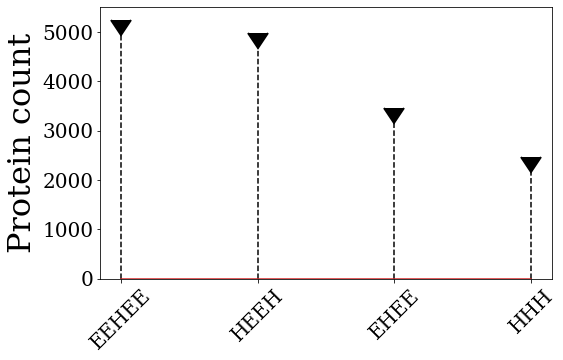

In [10]:
a = 5
plt.figure(figsize=(a*1.618,a))






(markers, stemlines, baseline) = plt.stem(
        data["topology"].value_counts().index,
        data["topology"].value_counts(),
        linefmt="--",
        markerfmt="o")

plt.setp(markers, marker=11, markersize=20, markeredgewidth=2,color='black')
plt.setp(stemlines,color='black')

plt.ylim(0)
plt.xticks(rotation=45,fontsize='20')
plt.yticks(fontsize="20")
plt.ylabel("Protein count",fontsize="32")
#plt.savefig("./SavedFigures/StemPlot.png",dpi=1200,bbox_inches='tight')
plt.show()

# Visualize Features for Classification

In [11]:
from HelperFunctions.feature_visualizations import show_all_plots

In [12]:
plt.rc('font', family='serif') # change font types for plots
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

## Topology-unspecified

Number of Unstable: 13442
number of Stable: 2717


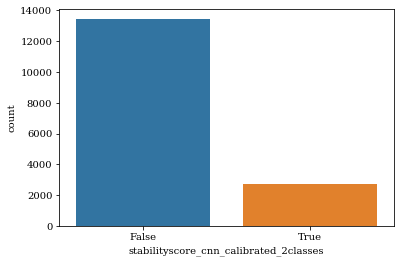

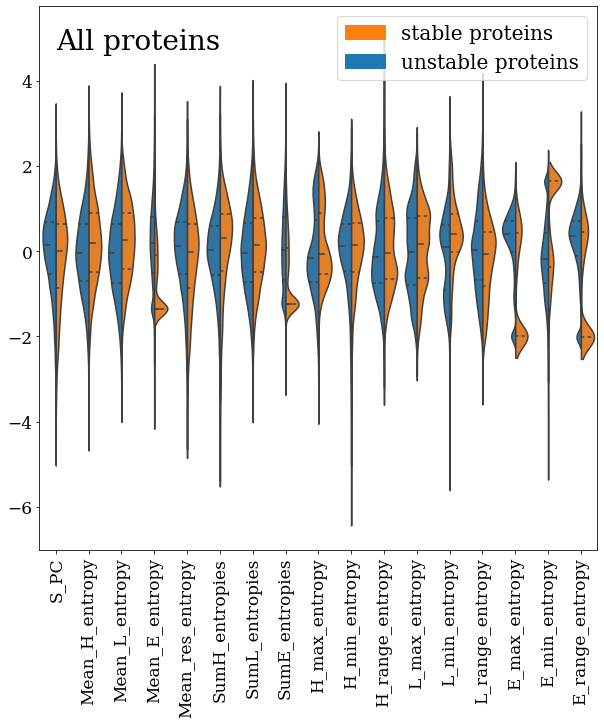

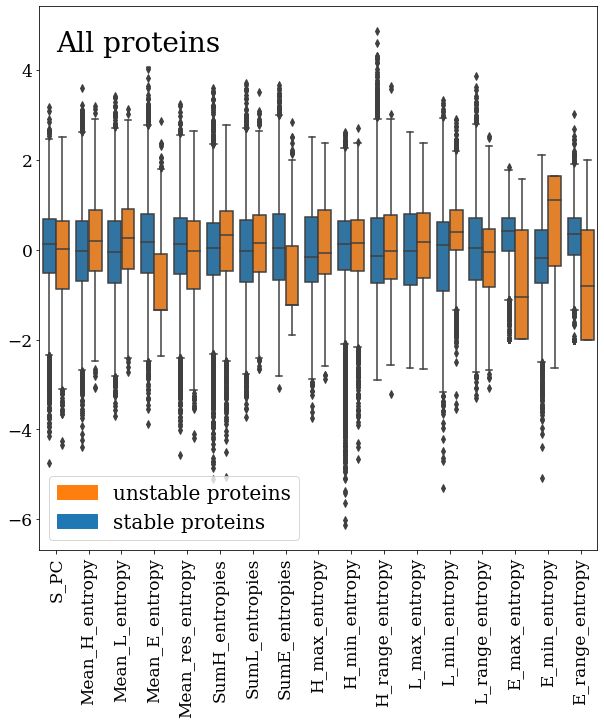

In [13]:
# show boxplot of all features (dataframe_visualizations/SD2 Feature Visualizations)
show_all_plots(data=data, 
               features=spc_features, 
               target='stabilityscore_cnn_calibrated_2classes',
               title_name='All proteins')


## Topology-specified

--------- Distributions for EEHEE topology ----------
Number of Unstable: 4669
number of Stable: 578


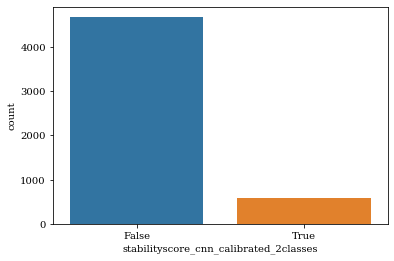

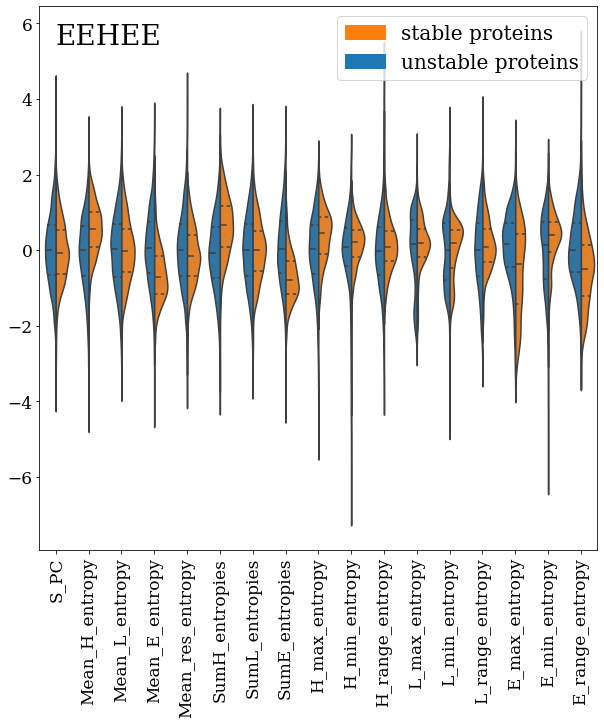

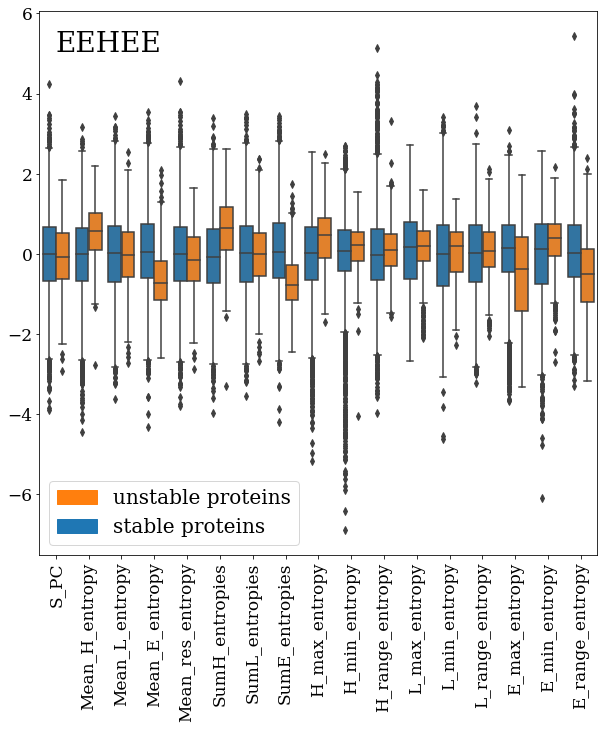

--------- Distributions for EHEE topology ----------
Number of Unstable: 2781
number of Stable: 676


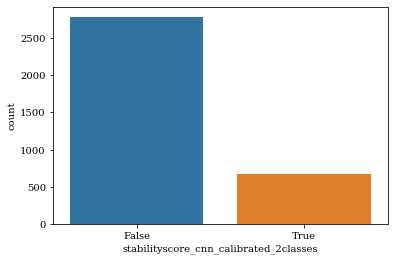

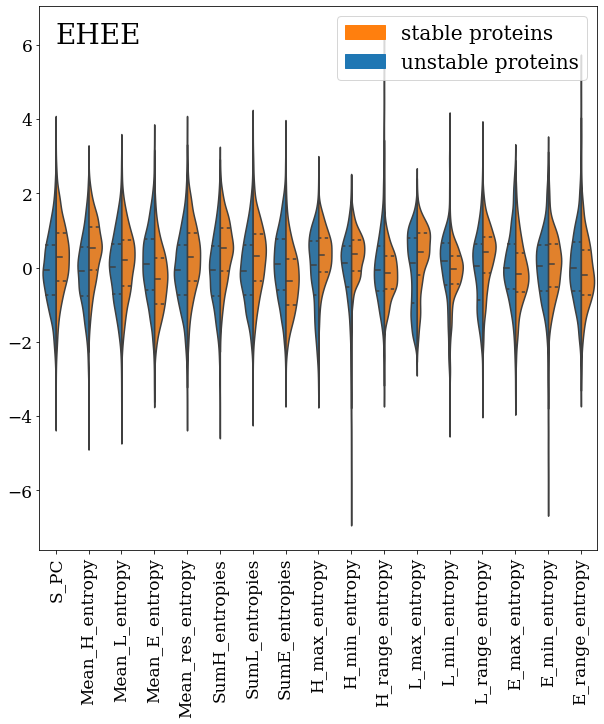

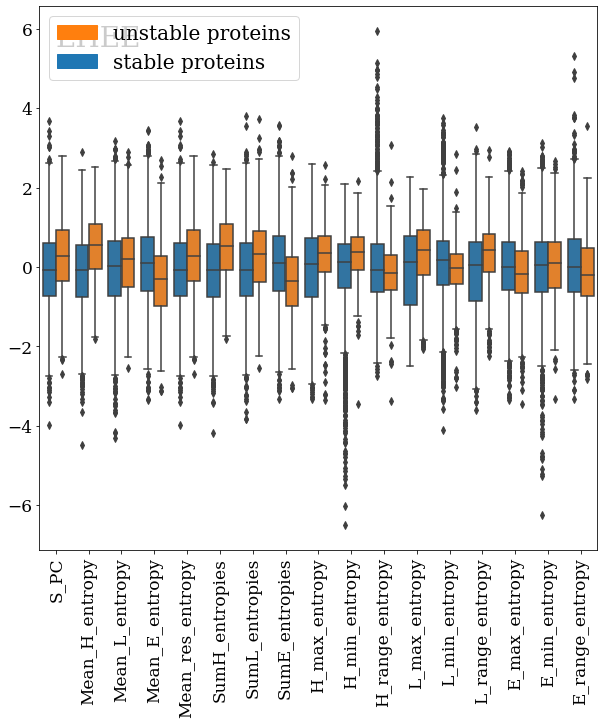

--------- Distributions for HEEH topology ----------
Number of Unstable: 4869
number of Stable: 117


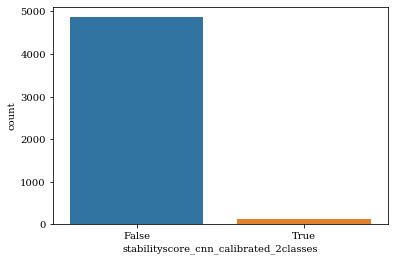

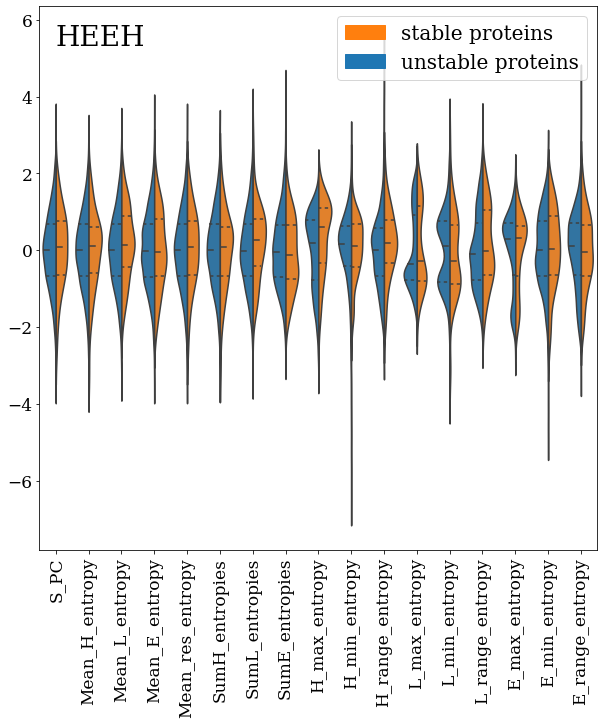

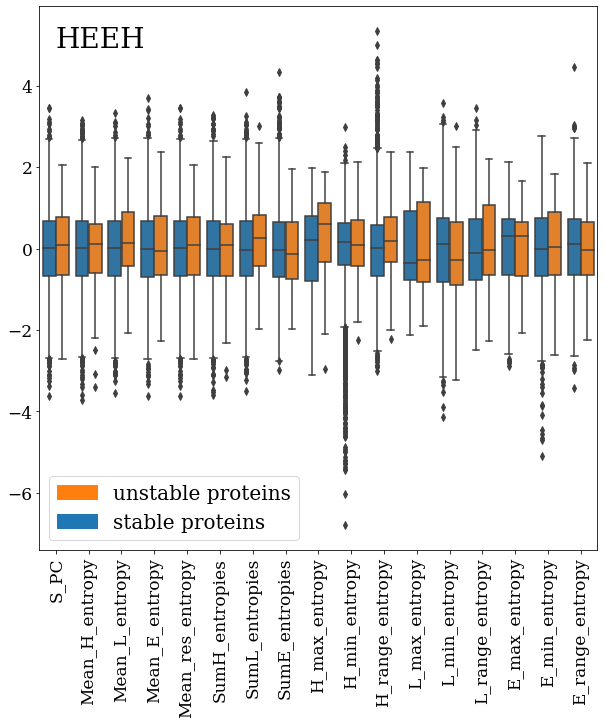

--------- Distributions for HHH topology ----------
Number of Unstable: 1346
number of Stable: 1123


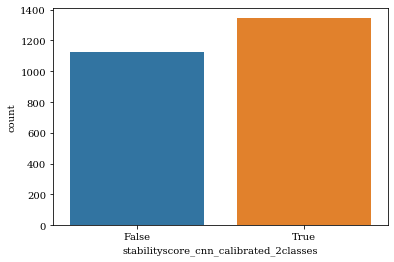

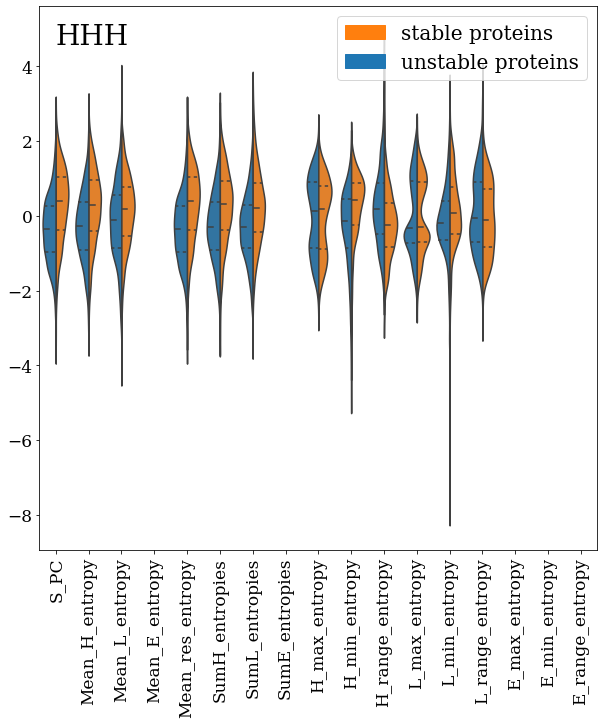

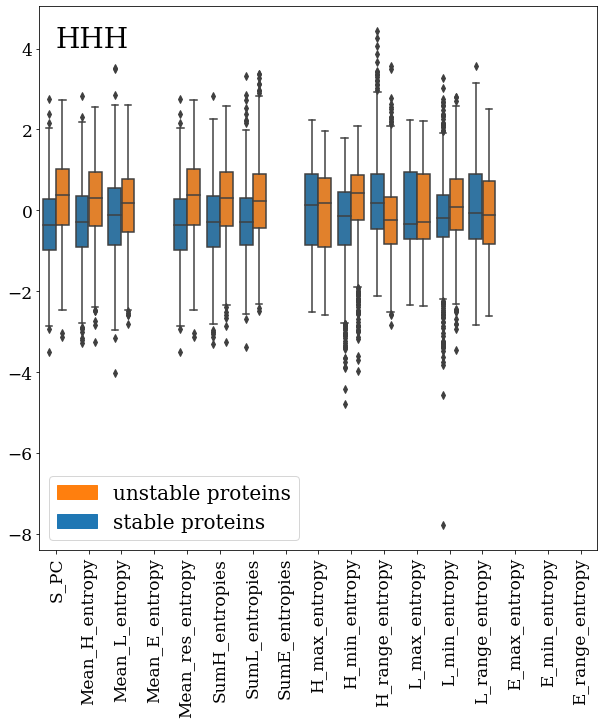

In [14]:
#show plots for all features per topology

#get a list of topologies
topologies_list = list(data['topology'].unique())

for topology in topologies_list:
    print("--------- Distributions for %s topology ----------"%topology)
    
    #subset the data to specify for a topology
    df = data[data['topology']==topology]
    
    #plot distributions for subset
    show_all_plots(data=df, 
               features=spc_features, 
               target='stabilityscore_cnn_calibrated_2classes',
               title_name='%s'%topology)

    

----------------------

# Kolmogorov-Smirnov (KS) Test for 'stable' and 'unstable' distributions

----------------------

## Topology-unspecified

In [15]:
from scipy.stats import ks_2samp

# get KS values for all features
rows = []
for fet in spc_features:
    subset_stable = stable_proteins[fet]
    subset_unstable = unstable_proteins[fet]
    
    ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
    rows.append([fet,ks_value,False,p_value]) #third row corresponds to 'is_rosetta' column

for fet in ros_features:
    subset_stable = stable_proteins[fet]
    subset_unstable = unstable_proteins[fet]
    
    ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
    rows.append([fet,ks_value,True,p_value])

    
    
#make a dataframe from ks value data
ks_values_all = pd.DataFrame(rows,columns=['Feature','KS','is_rosetta','P-value'])

#subset for entropy feature ks values and rosetta feature ks values
ks_values_all_spc = ks_values_all[ks_values_all['is_rosetta']==False]
ks_values_all_ros = ks_values_all[ks_values_all['is_rosetta']==True]


#get index of row with highest ks value for entropy and rosetta feature subset
spc_max_inx = ks_values_all_spc['KS'].idxmax()
ros_max_inx = ks_values_all_ros['KS'].idxmax()

In [16]:
print("Entropy feature with highest KS Value:\n",ks_values_all.iloc[spc_max_inx,:])
print()
print("Rosetta feature with highest KS Value\n",ks_values_all.iloc[ros_max_inx,:])

Entropy feature with highest KS Value:
 Feature       E_max_entropy
KS                 0.411855
is_rosetta            False
P-value                   0
Name: 14, dtype: object

Rosetta feature with highest KS Value
 Feature       score_per_res
KS                 0.648596
is_rosetta             True
P-value                   0
Name: 121, dtype: object


E_max_entropy is technically the largest KS value feature, but this difference is due to the fact that proteins which did not contain a beta sheet (i.e. HHH topology proteins) were filled in with a value of 0 for the beta sheet features. 

The next highest, non-beta-sheet-feature KS value was L_min_entropy, which all proteins contain. 

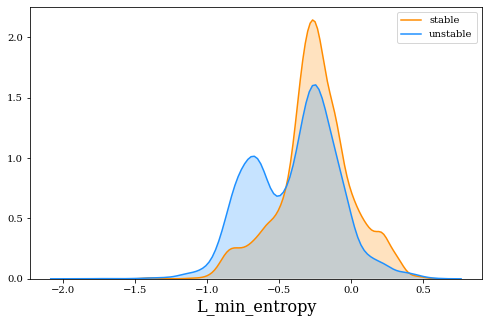

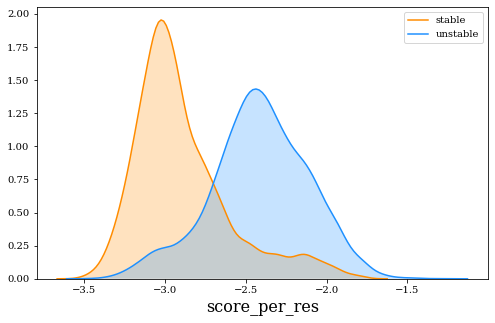

In [17]:
golden = (1 + 5 ** 0.5) / 2
fets = ['L_min_entropy','score_per_res']

f, __ = plt.subplots(0,0,figsize=[5*golden,5],subplot_kw={"aspect":golden})

fet = fets[0]
sns.kdeplot(data=stable_proteins[fet],label='stable',shade=True,color='darkorange')
sns.kdeplot(data=unstable_proteins[fet],label='unstable',shade=True,color='dodgerblue')
ax = plt.gca()
ax.set_xlabel("%s"%(fet),fontsize='16')

plt.gcf()

f, __ = plt.subplots(0,0,figsize=[5*golden,5],subplot_kw={"aspect":golden})

fet = fets[1]
sns.kdeplot(data=stable_proteins[fet],label='stable',shade=True,color='darkorange')
sns.kdeplot(data=unstable_proteins[fet],label='unstable',shade=True,color='dodgerblue')
ax = plt.gca()
ax.set_xlabel("%s"%(fet),fontsize='16')

plt.show()

In [18]:
# show entropy features ranked by KS value
ks_values_all_spc[ks_values_all_spc['P-value']<.05].sort_values(by='KS',ascending=False)

,Feature,KS,is_rosetta,P-value
14,E_max_entropy,0.411855,False,0.000000e+00
16,E_range_entropy,0.411855,False,0.000000e+00
15,E_min_entropy,0.409475,False,0.000000e+00
3,Mean_E_entropy,0.387047,False,1.625032e-294
7,SumE_entropies,0.387047,False,1.625032e-294
12,L_min_entropy,0.223941,False,7.082971e-99
5,SumH_entropies,0.135471,False,1.873223e-36
2,Mean_L_entropy,0.126050,False,1.285790e-31
13,L_range_entropy,0.101520,False,1.170066e-20
8,H_max_entropy,0.096512,False,1.035388e-18


Full list of KS values for Rosetta features

In [19]:
print(ks_values_all_ros.sort_values(by="KS",ascending=False).to_string())

                        Feature        KS  is_rosetta        P-value
121               score_per_res  0.648596        True   0.000000e+00
125                 total_score  0.609817        True   0.000000e+00
124              sum_best_frags  0.537013        True   0.000000e+00
128                 worst6frags  0.513865        True   0.000000e+00
27                avg_best_frag  0.490513        True   0.000000e+00
129                   worstfrag  0.490113        True   0.000000e+00
93            n_hydrophobic_noA  0.480544        True   0.000000e+00
83        largest_hphob_cluster  0.459792        True   0.000000e+00
79            hphob_sc_contacts  0.445630        True   0.000000e+00
81                     hxl_tors  0.442592        True   0.000000e+00
26                avg_all_frags  0.420281        True   0.000000e+00
34           buried_np_AFILMVWY  0.413371        True   0.000000e+00
109                  nres_sheet  0.411855        True   0.000000e+00
69                   frac_sheet  0

In [20]:
ks_values_all.sort_values(by="KS",ascending=False).to_csv("./data/KS_values_topology_unspecified.csv",index=False)

In [21]:
ks_values_all_ros[ks_values_all_ros["KS"]>0.2239]["Feature"].to_csv("./data/subset_rosetta_features_ROCKLIN.csv",index=False)

In [22]:
# number of ROS features that have a KS value greater than the highest Scnf feature
len(ks_values_all_ros[ks_values_all_ros["KS"]>0.2239]["Feature"])

55

In [23]:
# number of features the best Scnf feature is greater than
len(ros_features) - 55 

58

## Topology-specified

## N.B.:
* not all entropy features are showing for each topology because we are only showing those with p_value < .05

* **IMPORTANT**: SciPy _needs_ to be version 1.3.0, since its `ks_2samp` function is more accurate than the 1.2.x version I was previously using

In [24]:
rows = []

for topology in topologies_list:
    stable_top_specific = stable_proteins[stable_proteins['topology']==topology]
    unstable_top_specific = unstable_proteins[unstable_proteins['topology']==topology]
    

    for fet in spc_features:
        subset_stable = stable_top_specific[fet]
        subset_unstable = unstable_top_specific[fet]

        ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
        rows.append([fet,ks_value,False,topology,p_value]) #third row corresponds to 'is_rosetta' column

    for fet in ros_features:
        subset_stable = stable_top_specific[fet]
        subset_unstable = unstable_top_specific[fet]

        ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
        rows.append([fet,ks_value,True,topology,p_value])
    
    

In [25]:
ks_values_topology = pd.DataFrame(rows,columns=['Feature','KS','is_rosetta','topology','P-value'])
ks_values_topology_spc = ks_values_topology[ks_values_topology['is_rosetta']==False].reset_index(drop=True)
ks_values_topology_ros = ks_values_topology[ks_values_topology['is_rosetta']==True].reset_index(drop=True)

In [26]:
ks_values_topology_spc.sort_values(by="KS",ascending=False).to_csv("./data/KS_values_topology_specified_SPC.csv",index=False)

In [27]:
#show entropy features ranked by KS value for each topology.
df = ks_values_topology_spc[ks_values_topology_spc['P-value']<.05].sort_values(by='KS',ascending=False)
for topology in topologies_list:
    print("\t TOPOLOGY --> %s"%topology)
    print(df[df['topology']==topology])
    print()

	 TOPOLOGY --> EEHEE
             Feature        KS  is_rosetta topology       P-value
7     SumE_entropies  0.390694       False    EEHEE  1.288028e-68
3     Mean_E_entropy  0.352354       False    EEHEE  6.865644e-56
5     SumH_entropies  0.326313       False    EEHEE  5.395933e-48
1     Mean_H_entropy  0.299087       False    EEHEE  2.181930e-40
14     E_max_entropy  0.260885       False    EEHEE  7.858542e-31
16   E_range_entropy  0.231972       False    EEHEE  1.826183e-24
15     E_min_entropy  0.206728       False    EEHEE  1.617621e-19
8      H_max_entropy  0.203914       False    EEHEE  5.310072e-19
11     L_max_entropy  0.171692       False    EEHEE  1.355264e-13
13   L_range_entropy  0.163063       False    EEHEE  2.644994e-12
12     L_min_entropy  0.159669       False    EEHEE  8.160040e-12
10   H_range_entropy  0.141232       False    EEHEE  2.455558e-09
9      H_min_entropy  0.128253       False    EEHEE  8.967667e-08
4   Mean_res_entropy  0.104896       False    EEHEE  2.

In [28]:
#show Rosetta features ranked by KS value for each topology.
df = ks_values_topology_ros[ks_values_topology_ros['P-value']<.05].sort_values(by='KS',ascending=False)
for topology in topologies_list:
    print("\t TOPOLOGY --> %s"%topology)
    print(df[df['topology']==topology].iloc[:20,:])
    print()

	 TOPOLOGY --> EEHEE
                        Feature        KS  is_rosetta topology        P-value
76            n_hydrophobic_noA  0.706337        True    EEHEE  2.613753e-223
108                 total_score  0.705208        True    EEHEE  1.345907e-222
26            contig_not_hp_avg  0.695033        True    EEHEE  3.119842e-216
104               score_per_res  0.694713        True    EEHEE  4.925419e-216
85      net_atr_net_sol_per_res  0.683126        True    EEHEE  6.682987e-209
34          exposed_np_AFILMVWY  0.663757        True    EEHEE  3.013231e-197
17           buried_np_AFILMVWY  0.660052        True    EEHEE  4.680034e-195
66        largest_hphob_cluster  0.653585        True    EEHEE  2.922729e-191
37                       fa_atr  0.647276        True    EEHEE  1.355284e-187
33         exposed_hydrophobics  0.637154        True    EEHEE  8.707134e-182
18   buried_np_AFILMVWY_per_res  0.635847        True    EEHEE  4.820921e-181
86              net_atr_per_res  0.625548  

In [29]:
# Highest KS value for Entropy Feature in a topology:
spc_max_inx = ks_values_topology_spc['KS'].idxmax()

In [30]:
# Highest KS value for Rosetta Feature in a topology:
ros_max_inx = ks_values_topology_ros['KS'].idxmax()

In [31]:
print("Entropy feature-topology pair with highest KS Value:\n",ks_values_topology_spc.iloc[spc_max_inx,:])
print()
print("Rosetta feature-topology pair with highest KS Value\n",ks_values_topology_ros.iloc[ros_max_inx,:])

Entropy feature-topology pair with highest KS Value:
 Feature       SumE_entropies
KS                  0.390694
is_rosetta             False
topology               EEHEE
P-value          1.28803e-68
Name: 7, dtype: object

Rosetta feature-topology pair with highest KS Value
 Feature       n_hydrophobic_noA
KS                     0.706337
is_rosetta                 True
topology                  EEHEE
P-value            2.61375e-223
Name: 76, dtype: object


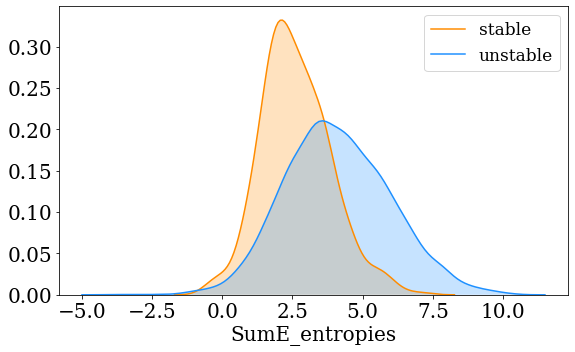

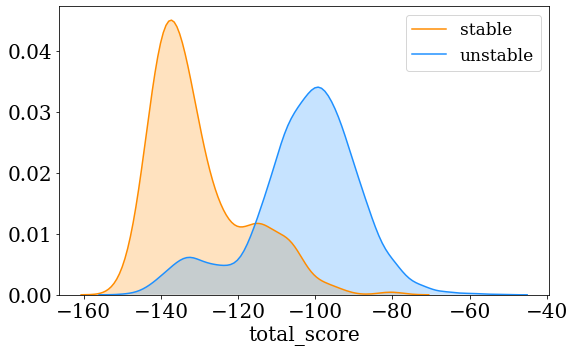

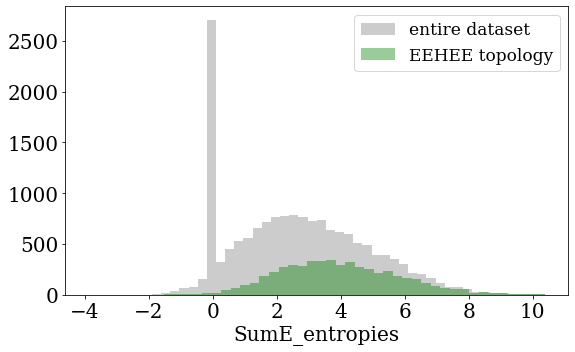

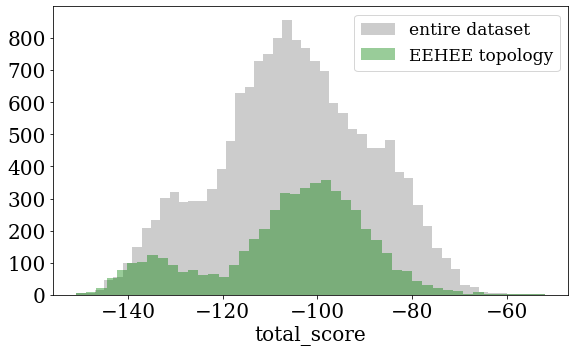

In [32]:
golden = (1 + 5 ** 0.5) / 2
fets = ['SumE_entropies','total_score']
top = "EEHEE"

### show kde plots for figures

f, __ = plt.subplots(0,0,figsize=[5*golden,5],subplot_kw={"aspect":golden})

fet = fets[0]
sns.kdeplot(data=stable_proteins[stable_proteins['topology']==top][fet],label='stable',shade=True,color='darkorange')
sns.kdeplot(data=unstable_proteins[unstable_proteins['topology']==top][fet],label='unstable',shade=True,color='dodgerblue')
ax = plt.gca()
plt.yticks(fontsize="20")
plt.xticks(fontsize="20")
ax.set_xlabel("%s"%(fet),fontsize='20')
plt.legend(fontsize='17')
plt.tight_layout()

#plt.savefig("./SavedFigures/Figure3d.png",dpi=300,bbox_anchor="tight")

f, __ = plt.subplots(0,0,figsize=[5*golden,5],subplot_kw={"aspect":golden})

fet = fets[1]
sns.kdeplot(data=stable_proteins[stable_proteins['topology']==top][fet],label='stable',shade=True,color='darkorange')
sns.kdeplot(data=unstable_proteins[unstable_proteins['topology']==top][fet],label='unstable',shade=True,color='dodgerblue')
ax = plt.gca()
plt.yticks(fontsize="20")
plt.xticks(fontsize="20")
ax.set_xlabel("%s"%(fet),fontsize='20')
plt.legend(fontsize='17')
plt.tight_layout()

#plt.savefig("./SavedFigures/Figure3c.png",dpi=300,bbox_anchor="tight")


### show distributions for plots
fet = fets[0]
f, __ = plt.subplots(0,0,figsize=[5*golden,5],subplot_kw={"aspect":golden})
sns.distplot(data[fet].values,label="entire dataset",color='gray',kde=False)
sns.distplot(data[data['topology']==top][fet].values,label='EEHEE topology',color='green',kde=False)
ax = plt.gca()
plt.yticks(fontsize="20")
plt.xticks(fontsize="20")
ax.set_xlabel("%s"%(fet),fontsize='20')
plt.legend(fontsize='17')
plt.tight_layout()

#plt.savefig("./SavedFigures/Figure3e.png",dpi=300,bbox_anchor="tight")

fet = fets[1]
f, __ = plt.subplots(0,0,figsize=[5*golden,5],subplot_kw={"aspect":golden})
sns.distplot(data[fet].values,label="entire dataset",color='gray',kde=False)
sns.distplot(data[data['topology']==top][fet].values,label='EEHEE topology',color='green',kde=False)
ax = plt.gca()
plt.yticks(fontsize="20")
plt.xticks(fontsize="20")
ax.set_xlabel("%s"%(fet),fontsize='20')
plt.legend(fontsize='17')
plt.tight_layout()

#plt.savefig("./SavedFigures/Figure3f.png",dpi=300,bbox_anchor="tight")

plt.show()

----------------------

# Epps-Singleton (ES) Test for 'stable' and 'unstable' distributions

----------------------

## Topology-unspecified

In [33]:
# get ES values for all features
rows = []
for fet in spc_features:
    try:
        subset_stable = stable_proteins[fet]
        subset_unstable = unstable_proteins[fet]

        es_value, p_value = epps_singleton_2samp(subset_stable,subset_unstable)
        rows.append([fet,es_value,False,p_value]) #third row corresponds to 'is_rosetta' column
    except:
        print("%s Feature did not work"%fet)
for fet in ros_features:
    try:
        subset_stable = stable_proteins[fet]
        subset_unstable = unstable_proteins[fet]
    
        es_value, p_value = epps_singleton_2samp(subset_stable,subset_unstable)
        rows.append([fet,es_value,True,p_value])
    except:
        print("%s Feature did not work"%fet)
    

buns_sc_heavy Feature did not work
dslf_fa13 Feature did not work
entropy Feature did not work
ss_contributes_core Feature did not work


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_hypotests.py:106: RuntimeWarning: divide by zero encountered in true_divide
  ts = np.reshape(t, (-1, 1)) / sigma
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_hypotests.py:109: RuntimeWarning: invalid value encountered in multiply
  gx = np.vstack((np.cos(ts*x), np.sin(ts*x))).T  # shape = (nx, 2*len(t))
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_hypotests.py:109: RuntimeWarning: invalid value encountered in cos
  gx = np.vstack((np.cos(ts*x), np.sin(ts*x))).T  # shape = (nx, 2*len(t))
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_hypotests.py:109: RuntimeWarning: invalid value encountered in sin
  gx = np.vstack((np.cos(ts*x), np.sin(ts*x))).T  # shape = (nx, 2*len(t))
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_hypotests.py:110: RuntimeWarning: invalid value encountered in multiply
  gy = np.vstack((np.cos(ts*y), np.sin(ts*y))).T
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats

In [34]:
#make a dataframe from ES value data
es_values_all = pd.DataFrame(rows,columns=['Feature','ES','is_rosetta','P-value'])

#subset for entropy feature ks values and rosetta feature ks values
es_values_all_spc = es_values_all[es_values_all['is_rosetta']==False]
es_values_all_ros = es_values_all[es_values_all['is_rosetta']==True]


#get index of row with highest ks value for entropy and rosetta feature subset
spc_max_inx = es_values_all_spc['ES'].idxmax()
ros_max_inx = es_values_all_ros['ES'].idxmax()

In [35]:
print("Entropy feature with highest ES Value:\n",es_values_all.iloc[spc_max_inx,:])
print()
print("Rosetta feature with highest ES Value\n",es_values_all.iloc[ros_max_inx,:])

Entropy feature with highest ES Value:
 Feature       Mean_E_entropy
ES                   2575.15
is_rosetta             False
P-value                    0
Name: 3, dtype: object

Rosetta feature with highest ES Value
 Feature       frac_helix
ES               7649.79
is_rosetta          True
P-value                0
Name: 64, dtype: object


In [36]:
# show entropy features ranked by ES value
es_values_all_spc[es_values_all_spc['P-value']<.05].sort_values(by='ES',ascending=False)

,Feature,ES,is_rosetta,P-value
3,Mean_E_entropy,2575.146919,False,0.000000e+00
15,E_min_entropy,2111.045611,False,0.000000e+00
16,E_range_entropy,2047.371809,False,0.000000e+00
14,E_max_entropy,1880.525289,False,0.000000e+00
7,SumE_entropies,1539.284865,False,0.000000e+00
12,L_min_entropy,846.552896,False,6.324457e-182
13,L_range_entropy,445.712658,False,3.670249e-95
8,H_max_entropy,335.910767,False,1.930527e-71
5,SumH_entropies,320.271914,False,4.581735e-68
2,Mean_L_entropy,316.016962,False,3.794974e-67


## Topology-specified

## N.B.:
* not all entropy features are showing for each topology because we are only showing those with p_value < .05

* **IMPORTANT**: SciPy _needs_ to be version 1.3.0, since its `epps_singleton_2samp` function is more accurate than the 1.2.x version I was previously using

In [37]:
rows = []

for topology in topologies_list:
    stable_top_specific = stable_proteins[stable_proteins['topology']==topology]
    unstable_top_specific = unstable_proteins[unstable_proteins['topology']==topology]
    
    #print("\t%s"%topology)
    for fet in spc_features:
        try:
            subset_stable = stable_top_specific[fet]
            subset_unstable = unstable_top_specific[fet]

            es_value, p_value = epps_singleton_2samp(subset_stable,subset_unstable)
            rows.append([fet,es_value,False,topology,p_value]) #third row corresponds to 'is_rosetta' column
        except:
            #print("%s Feature in %s topology did not work"%(fet,topology))
            pass
    print()
    for fet in ros_features:
        try:
            subset_stable = stable_top_specific[fet]
            subset_unstable = unstable_top_specific[fet]

            es_value, p_value = epps_singleton_2samp(subset_stable,subset_unstable)
            rows.append([fet,es_value,True,topology,p_value])
        except:
            #print("%s Feature in %s topology did not work"%(fet,topology))
            pass
    #print()
    #print()

es_values_topology = pd.DataFrame(rows,columns=['Feature','ES','is_rosetta','topology','P-value'])
es_values_topology_spc = es_values_topology[es_values_topology['is_rosetta']==False].reset_index(drop=True)
es_values_topology_ros = es_values_topology[es_values_topology['is_rosetta']==True].reset_index(drop=True)

#show entropy features ranked by KS value for each topology.
df = es_values_topology_spc[es_values_topology_spc['P-value']<.05].sort_values(by='ES',ascending=False)
for topology in topologies_list:
    print("\t TOPOLOGY --> %s"%topology)
    print(df[df['topology']==topology])
    print()

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_hypotests.py:106: RuntimeWarning: divide by zero encountered in true_divide
  ts = np.reshape(t, (-1, 1)) / sigma
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_hypotests.py:109: RuntimeWarning: invalid value encountered in multiply
  gx = np.vstack((np.cos(ts*x), np.sin(ts*x))).T  # shape = (nx, 2*len(t))
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_hypotests.py:109: RuntimeWarning: invalid value encountered in cos
  gx = np.vstack((np.cos(ts*x), np.sin(ts*x))).T  # shape = (nx, 2*len(t))
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_hypotests.py:109: RuntimeWarning: invalid value encountered in sin
  gx = np.vstack((np.cos(ts*x), np.sin(ts*x))).T  # shape = (nx, 2*len(t))
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_hypotests.py:110: RuntimeWarning: invalid value encountered in multiply
  gy = np.vstack((np.cos(ts*y), np.sin(ts*y))).T
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats



	 TOPOLOGY --> EEHEE
             Feature          ES  is_rosetta topology        P-value
7     SumE_entropies  989.227559       False    EEHEE  7.710957e-213
1     Mean_H_entropy  684.924934       False    EEHEE  6.402057e-147
3     Mean_E_entropy  624.136624       False    EEHEE  9.248967e-134
5     SumH_entropies  617.499251       False    EEHEE  2.527855e-132
12     L_min_entropy  444.939407       False    EEHEE   5.393293e-95
8      H_max_entropy  360.705349       False    EEHEE   8.557611e-77
10   H_range_entropy  321.335534       False    EEHEE   2.700840e-68
11     L_max_entropy  288.907092       False    EEHEE   2.675139e-61
9      H_min_entropy  268.180507       False    EEHEE   7.869858e-57
13   L_range_entropy  260.293175       False    EEHEE   3.942868e-55
16   E_range_entropy  254.424804       False    EEHEE   7.249127e-54
15     E_min_entropy  207.027263       False    EEHEE   1.158174e-43
4   Mean_res_entropy  196.551272       False    EEHEE   2.071459e-41
14     E_ma

In [38]:
# Highest KS value for Entropy Feature in a topology:
spc_max_inx = es_values_topology_spc['ES'].idxmax()

# Highest KS value for Rosetta Feature in a topology:
ros_max_inx = es_values_topology_ros['ES'].idxmax()

print("Entropy feature with highest ES Value:\n",es_values_topology_spc.iloc[spc_max_inx,:])
print()
print("Rosetta feature with highest ES Value\n",es_values_topology_ros.iloc[ros_max_inx,:])

Entropy feature with highest ES Value:
 Feature       SumE_entropies
ES                   989.228
is_rosetta             False
topology               EEHEE
P-value         7.71096e-213
Name: 7, dtype: object

Rosetta feature with highest ES Value
 Feature       n_hydrophobic_noA
ES                      5757.91
is_rosetta                 True
topology                  EEHEE
P-value                       0
Name: 72, dtype: object


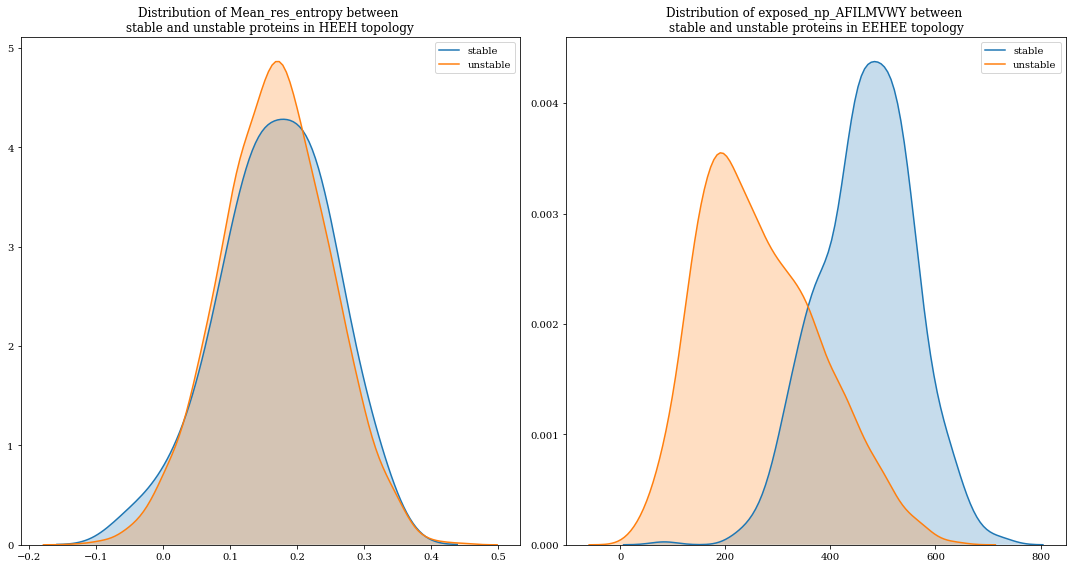

In [39]:
pairs = (['HEEH','Mean_res_entropy'],['EEHEE','exposed_np_AFILMVWY'])
f, ax = plt.subplots(1,2,figsize=[15,8])
for i in range(len(pairs)):
    top, fet = pairs[i]
    sns.kdeplot(data=stable_proteins[stable_proteins['topology']==top][fet],label='stable',shade=True,ax=ax[i])
    sns.kdeplot(data=unstable_proteins[unstable_proteins['topology']==top][fet],label='unstable',shade=True,ax=ax[i])
    ax[i].set_title("Distribution of %s between \nstable and unstable proteins in %s topology"%(fet,top))
    
plt.tight_layout()

# Stability Probabilities Barplot

In [40]:
def stability_probabilities_barplt(feature,df,step=0.1,topology_label='all',stability_bool=False,stable_col='stable?',by_binary=False):
    """
    Takes a dataframe and returns the list of probabilities that the protein will be either stable 
    or unstable for each value in the bin_list.
    
    Takes a list of bin values, a target feature, a topoogy,a stability target (stable or unstable),
    and a name for the stability column to use as reference. 
    """
    #get bin_list
    bin_list = create_bin_list(df, feature, step)
    print("Step 1: Made a list of bins")
    print("--> %s" %bin_list)
    print("LEN --> %s"%len(bin_list))
    
    #create a df with binned_values
    df = get_binned_df(df, feature, bin_list=bin_list,stable_col=stable_col,by_binary=by_binary)
    print("Step 2: Made a dataframe that had the 'bin value' of each row.")
    print("'binned values column: \n",df['binned_values'].values)
    
    #make a list of tuple percents of being stable or unstable depending on bin value
    percents_list,totals_list, stable_count, unstable_count = get_percents_list(df, bin_list, stable_col=stable_col) 
    print("Step 3: Made a list of percent of stable vs. unstable in each bin")
    print("List of these percentages:",percents_list)
    
    print("Totals list:",totals_list)
    print("LEN --> %s"%len(totals_list))
    
    
    stability_list = [i[0] for i in percents_list] if stability_bool==True else [i[1] for i in percents_list]

    print("LEN STABILITY LIST\n -->%s"%len(stability_list))
    
    f,ax = bar_plot(bin_list,stability_list,stability_bool,totals_list,step)
    
    #plot number of stable and unstable
#     plt.scatter(x=bin_list, y=stable_count,label='number of stable',color='black')
#     plt.scatter(x=bin_list, y=unstable_count,label='number of unstable')
    plt.legend()
    
    
    return f,ax

def create_bin_list(df, feature, step):
    #create bin_list
    max_feature_val = round(max(df[feature]),2)
    min_feature_val = round(min(df[feature]),2)
    bin_list = np.arange(min_feature_val,max_feature_val+step,step)
    return bin_list

def get_binned_df(df,feature, bin_list,pred_col=None, stable_col='stable?',by_binary=False):
    
    # get indices through digitize_bins
    ind = digitize_bins(df=df, feature=feature, bin_values_list=bin_list)
    
    # get binned_values
    binned_values = get_binned_values(ind, bin_list=bin_list)
    
    # add binned_values to df
    df['binned_values'] = binned_values
    
    return df

def digitize_bins(df,feature, bin_values_list):
    """
    Takes a dataframe, specified features, and bin values
    and returns indices for the df values for the bin values.
    
    Example usage:
    >>> df = pd.DataFrame([[0,4,2,6,3,2],[1,4,2,1,3,2],[12,4,1,2,2,4]])
    >>> digitize_bins(df, feature=0, bin_values_list=[2,4])
    array([0, 0, 2])
    
    """
    x = df[feature].values
    inds = np.digitize(x,bin_values_list,right=True)
    inds = chk_inds(inds, len(bin_values_list))
    return inds
    

def get_binned_values(ind, bin_list):
#     print('bin_list:',bin_list)
#     print('max ind:',max(list(ind)))
    binned_values=[]
    for i in ind:
        #print(i)
        binned_values.append(bin_list[i])
    return binned_values

def get_percents_list(df, bin_list, stable_col='stable?'):
    
    percents_list = []
    totals_list = []
    
    stable_count = []
    unstable_count = []
    
    for i in bin_list:
        # find where df has 
        specified_df = df[df['binned_values']==i].copy()
        
        # find positive and negatives values to for this VAL specific df
        stable, unstable = specified_df[specified_df[stable_col]==1].copy(), specified_df[specified_df[stable_col]==0].copy()
        
        # get number of stable and unstable examples
        n_stable = len(stable)
        n_unstable = len(unstable)
        #if the sum of stable and unstable is 0, then make 'total' slightly non-zero to not break code
        total = n_stable+n_unstable if (n_stable+n_unstable)!=0 else 0.0000000001 
        
        #keep track of how many stable and unstables we have per bin, for debugging
        stable_count.append(n_stable)
        unstable_count.append(n_unstable)
        
        # get percent of positive and negative
        p_stable = n_stable/(total)
        p_unstable = n_unstable/(total)
        
        percents_list.append((p_stable,p_unstable))
        totals_list.append(total)
    
    return percents_list, totals_list, stable_count,unstable_count
     

def specify_stability(probabilities_list, stability_bool):
    stability_list = []
    tuple_inx = None
    if stability_bool:
        tuple_inx=0
    else:
        tuple_inx=1
    for i in probabilities_list:
        stability_list.append(i[tuple_inx])
    return stability_list
        

def bar_plot(bin_list, stability_list, stability_bool,totals_list,step):
    
    stability_label = 'stable' if stability_bool else 'unstable'
    
    f,ax = plt.subplots()
    plt.bar(x=[i+step for i in bin_list],height=stability_list,width=step,color='darkorange',facecolor='none',edgecolor='black')
    ax2 = ax.twinx()
    plt.scatter(x=bin_list,y=totals_list,label='protein count')
    ax2.set_ylabel("count of proteins per bin",rotation="270",fontsize='14')
    ax2.yaxis.set_label_coords(1.125,.525)
    ax2.set_ylim(bottom=0)
    ax.set_ylabel("Fraction of %s per bin"%stability_label,fontsize='14')
    ax.set_xlabel("SumE_entropies values",fontsize=14)

    return f,ax

def chk_inds(ndarray, max_val):
    return [(max_val-1) if x==max_val else x for x in ndarray]


Step 1: Made a list of bins
--> [-3.89 -2.89 -1.89 -0.89  0.11  1.11  2.11  3.11  4.11  5.11  6.11  7.11
  8.11  9.11 10.11 11.11]
LEN --> 16
Step 2: Made a dataframe that had the 'bin value' of each row.
'binned values column: 
 [3.11 3.11 5.11 ... 2.11 2.11 4.11]
Step 3: Made a list of percent of stable vs. unstable in each bin
List of these percentages: [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.18, 0.82), (0.21212121212121213, 0.7878787878787878), (0.2792642140468227, 0.7207357859531772), (0.18105263157894738, 0.8189473684210526), (0.10875331564986737, 0.8912466843501327), (0.046840958605664486, 0.9531590413943355), (0.02664796633941094, 0.9733520336605891), (0.005012531328320802, 0.9949874686716792), (0.005263157894736842, 0.9947368421052631), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]
Totals list: [1, 1, 2, 9, 50, 198, 598, 950, 1131, 918, 713, 399, 190, 62, 22, 3]
LEN --> 16
LEN STABILITY LIST
 -->16


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


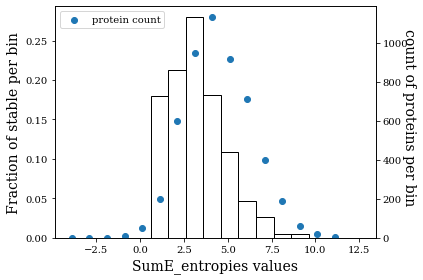

In [42]:
f, ax = stability_probabilities_barplt('SumE_entropies',
                               data[data["topology"]=="EEHEE"], 
                               stable_col='stabilityscore_cnn_calibrated_2classes',
                               stability_bool=True,
                               step=1)

plt.legend(loc='upper left')
plt.xlabel("SumE_entropies value",fontsize='14')
plt.tight_layout()

#plt.savefig("./SavedFigures/StabilityProbabilitiesBarplt",dpi=300,bbox_inches="tight")